In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr, pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import shap
import warnings
warnings.filterwarnings('ignore')

RESOLUTION = 25
window_size = 201

l1_alpha = 0.001

assays = ['DNase', 'H3K36me3', 'H3K27me3', 'H3K27ac', 'H3K4me1', 'H3K4me3', 'H3K9me3']
assay_index = 7  # 1 through 7; this is the assay that's concatenated with H3K27ac in the input features

In [2]:
colnames = ["pos_" + str(x) for x in list(range(-(window_size//2), (window_size//2) + 1))]
colnames = colnames + ["log10p1(TPM)", "cell_type", "chrom", "position", "strand", "assay_index"] 
df = pd.read_csv('../Data/T.2', sep=",", names=colnames, low_memory=False)
df

,pos_-100,pos_-99,pos_-98,pos_-97,pos_-96,pos_-95,pos_-94,pos_-93,pos_-92,pos_-91,...,pos_97,pos_98,pos_99,pos_100,log10p1(TPM),cell_type,chrom,position,strand,assay_index
0,0.059135,0.037845,0.037845,0.012462,0.001679,0.001679,0.001679,0.001679,0.005073,0.011078,...,0.142584,0.170865,0.170865,0.158394,0.000000,T07,chr12,2097374,-,1
1,0.113359,0.123887,0.160679,0.203824,0.139379,0.235550,0.139379,0.124279,0.013866,0.017162,...,0.119884,0.194636,0.219547,0.027963,0.000000,T07,chr12,2097374,-,2
2,0.377263,0.338279,0.386069,0.333437,0.344931,0.348895,0.367963,0.375170,0.314022,0.309879,...,0.556164,0.500170,0.527139,0.529947,0.000000,T07,chr12,2097374,-,3
3,0.052612,0.044864,0.023410,0.012634,0.012413,0.091235,0.149084,0.179246,0.310483,0.345425,...,0.453805,0.541333,0.605782,0.782368,0.000000,T07,chr12,2097374,-,4
4,0.005353,0.020506,0.026360,0.024074,0.034308,0.036804,0.036804,0.164324,0.321966,0.247768,...,0.237406,0.311340,0.342509,0.341111,0.000000,T07,chr12,2097374,-,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,0.201001,0.097090,0.097236,0.100359,0.100723,0.101168,0.102575,0.102575,0.102575,0.102575,...,0.355630,0.355630,0.355630,0.288562,0.060698,T03,chr8,4381625,+,3
104996,0.083670,0.083670,0.083804,0.086686,0.087021,0.087441,0.088771,0.088771,0.088771,0.088771,...,0.113668,0.113668,0.113668,0.113668,0.060698,T03,chr8,4381625,+,4
104997,0.761586,0.761586,0.748650,0.520173,0.508339,0.117927,0.097549,0.098514,0.098514,0.099438,...,0.108074,0.108745,0.109061,0.109061,0.060698,T03,chr8,4381625,+,5
104998,0.115736,0.529933,0.571288,0.570411,0.430682,0.114098,0.114711,0.115736,0.115736,0.116725,...,0.126025,0.126738,0.127073,0.122102,0.060698,T03,chr8,4381625,+,6


In [3]:
df_sorted = df.sort_values(['chrom', 'position', 'cell_type', 'assay_index'], ascending=[1, 1, 1, 1])
df_sorted_unique = df_sorted.drop_duplicates()
df_H3K27ac = df_sorted_unique.iloc[range(4-1, len(df_sorted_unique), 7), :]
df_other_assay = df_sorted_unique.iloc[range(assay_index-1, len(df_sorted_unique), 7), :]
df_merged = pd.merge(df_H3K27ac, df_other_assay, on=['cell_type', 'chrom', 'position', 'strand'], suffixes=['_H3K27ac', '_'+assays[assay_index-1]])
df_processed = df_merged.iloc[:, np.r_[0:window_size, (window_size + 6):(window_size + 6 + window_size + 1), window_size + 2]]
df_processed

,pos_-100_H3K27ac,pos_-99_H3K27ac,pos_-98_H3K27ac,pos_-97_H3K27ac,pos_-96_H3K27ac,pos_-95_H3K27ac,pos_-94_H3K27ac,pos_-93_H3K27ac,pos_-92_H3K27ac,pos_-91_H3K27ac,...,pos_93_H3K9me3,pos_94_H3K9me3,pos_95_H3K9me3,pos_96_H3K9me3,pos_97_H3K9me3,pos_98_H3K9me3,pos_99_H3K9me3,pos_100_H3K9me3,log10p1(TPM)_H3K9me3,chrom
0,0.025629,0.005392,0.004540,0.026788,0.026788,0.027208,0.027596,0.027596,0.027596,0.050284,...,0.008317,0.008709,0.001439,0.001439,0.000950,0.000080,0.000080,0.001113,1.016197,chr10
1,0.061047,0.028103,0.013064,0.013064,0.013064,0.031084,0.076954,0.089118,0.089118,0.089118,...,0.070533,0.078700,0.078700,0.078700,0.068064,0.021364,0.006942,0.003193,0.984077,chr10
2,0.174993,0.037691,0.074260,0.163833,0.071584,0.004139,0.032441,0.083342,0.160610,0.124576,...,0.418265,0.156992,0.065637,0.028770,0.023673,0.047700,0.159420,0.228115,0.851258,chr10
3,0.906261,0.879054,0.649801,0.772441,0.831998,0.802663,0.936844,1.304763,1.507471,1.884622,...,0.162253,0.149144,0.144328,0.021194,0.021194,0.021194,0.149144,0.163473,1.724440,chr10
4,0.119760,0.050608,0.050608,0.051585,0.288556,0.390106,0.533995,0.549299,0.576813,0.618025,...,0.244289,0.248733,0.241869,0.235824,0.237477,0.238526,0.222668,0.224108,1.689220,chr10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13541,0.451991,0.906261,0.698156,0.869818,0.976220,1.215698,1.136422,0.922986,0.653091,0.772441,...,0.201495,0.201634,0.203207,0.207242,0.090698,0.035465,0.027479,0.027479,0.485721,chr9
13542,0.445411,0.550189,0.441744,0.218291,0.218393,0.199379,0.020982,0.020743,0.020665,0.118981,...,0.631212,0.761679,0.783444,0.936993,0.818891,0.252729,0.098015,0.174704,0.909556,chr9
13543,0.224954,0.227263,0.224849,0.050002,0.023306,0.023929,0.024566,0.024346,0.024217,0.024238,...,0.541456,0.291191,0.159406,0.291417,0.557847,0.345361,0.413254,0.386764,0.004321,chr9
13544,0.208416,0.218870,0.027839,0.016385,0.254112,0.438984,0.430758,0.420190,0.473723,0.462777,...,0.053806,0.028465,0.041807,0.047199,0.043469,0.179392,0.179392,0.179392,1.030195,chr9


In [4]:
even_chroms = ["chr" + str(c) for c in range(2,23,2)]
df_even_chroms = df_processed.loc[df_processed['chrom'].isin(even_chroms)]
xTrain = df_even_chroms.iloc[:, window_size:window_size + window_size] # CHANGE TO EXCLUDE H3K27ac
yTrain = df_even_chroms.iloc[:, window_size + window_size]

odd_chroms = ["chr" + str(c) for c in range(1,23,2)]
df_odd_chroms = df_processed.loc[df_processed['chrom'].isin(odd_chroms)]
xTest = df_odd_chroms.iloc[:, window_size:window_size + window_size]
yTest = df_odd_chroms.iloc[:, window_size + window_size]

# xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.30, random_state=42)
(xTrain.shape, xTest.shape, yTrain.shape, yTest.shape)

((9457, 201), (4089, 201), (9457,), (4089,))

In [5]:
# model = linear_model.LinearRegression()
# model = linear_model.ElasticNet(alpha=l1_alpha, l1_ratio=1.0, max_iter=1000)
model = RandomForestRegressor(verbose=0, n_estimators=100, n_jobs=4)
model.fit(xTrain.iloc[:-1,:], yTrain.iloc[:-1])

RandomForestRegressor(n_jobs=4)

In [6]:
yTrain_Pred = model.predict(xTrain)
yTest_Pred = model.predict(xTest)
mse_Train = mean_squared_error(yTrain, yTrain_Pred)
pc_Train, _ = pearsonr(yTrain, yTrain_Pred)
sc_Train, _ = spearmanr(yTrain, yTrain_Pred)
mse_Test = mean_squared_error(yTest, yTest_Pred)
pc_Test, _ = pearsonr(yTest, yTest_Pred)
sc_Test, _ = spearmanr(yTest, yTest_Pred)

print("Train: MSE = ", round(mse_Train, 3), "Pearson =", round(pc_Train, 3), "Spearman =", round(sc_Train, 3))
print("Test: MSE = ", round(mse_Test, 3), "Pearson =", round(pc_Test, 3), "Spearman =", round(sc_Test, 3))

Train: MSE =  0.034 Pearson = 0.979 Spearman = 0.919
Test: MSE =  0.262 Pearson = 0.258 Spearman = 0.276


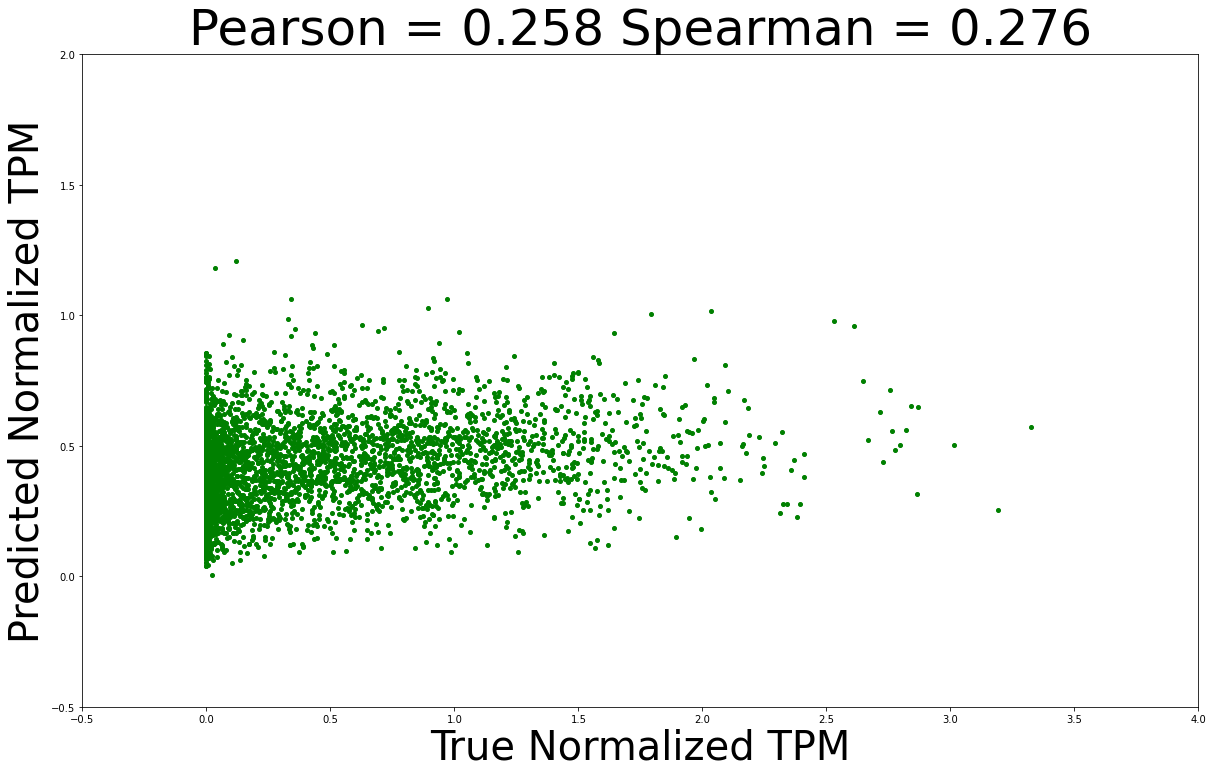

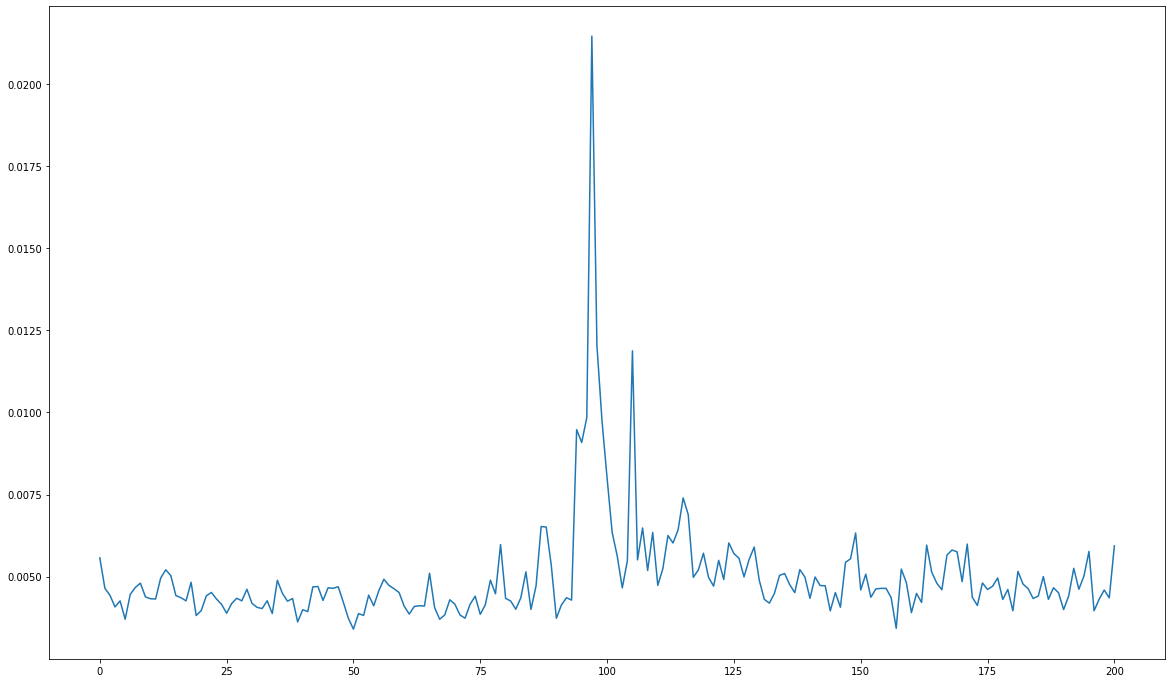

In [7]:
plt.rcParams["figure.figsize"] = (20, 12)
plt.plot(yTest, yTest_Pred, 'o', markersize=4, color='green')
plt.xlabel("True Normalized TPM", size=40)
plt.ylabel("Predicted Normalized TPM", size=40)
plt.xlim(-0.5, 4)
plt.ylim(-0.5, 2)
plt.title("Pearson = "+str(round(pc_Test, 3))+" Spearman = "+str(round(sc_Test, 3)), size=50)
plt.show()

plt.plot(model.feature_importances_) # (model.coef_)
plt.show()

In [8]:
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(xTrain.iloc[:10, :])
# shap.summary_plot(shap_values, xTrain.iloc[:10, :])
# shap.plots.beeswarm(shap_values, xTest.iloc[:10, :])

In [9]:
# Define in-silico epigenesis for a pair of input assays where the first assay is H3K27ac
def ise(gene, trained_model, assay_index, inserted_minuslog10p_value = 3, peak_width = 2):
    
    X = np.load(gene + ".npy")
    
    # Perform inference by introducing p-value changes with a peak width
    yPred = []
    center = window_size // 2
    positions = range(center - center, center + center + 1)
    for pos in positions:
        X_modified = np.copy(X)
        # TODO: Calculate number of bins exactly
        for p in range(pos - peak_width // 2, pos + peak_width // 2 + 1):
            if( (p>=0) and (p < max(positions)) ):
                if(X_modified[:, p, 2] > 1.1):
                    # If H3K27me3 peak exists, then p300 doesn't work
                    pass
                else:
                    X_modified[:, p, 3] += inserted_minuslog10p_value

        # Prepare input for simple model
        X_modified = np.concatenate([X_modified[:, :, 3], X_modified[:, :, assay_index]], axis=1)

        yPred_value = trained_model.predict(X_modified)
        yy = yPred_value[0]
        yPred.append(yy)
    
    # Prepare input for simple model
    X = np.concatenate([X[:, :, 3], X[:, :, assay_index]], axis=1) 

    # Instead of scaling, divide by yPred
    yPred_value = trained_model.predict(X)[0]
    yPred = (np.power(10, yPred) -1) / (np.power(10, yPred_value) -1)

    return yPred


def p_value_mapping(inserted_minuslog10p_value):
    minuslog10p_value = np.expm1(inserted_minuslog10p_value)
    p_value = np.power(10, -1 * minuslog10p_value)
    return round(minuslog10p_value, 2)


def assay_name(assay):
    return assays[assay]


# Load Alan's H3K27ac p300 dataset
df_CXCR4 = pd.read_csv("../Data/CXCR4.p300.tsv", sep="\t")
df_CXCR4_values = df_CXCR4[df_CXCR4['Position_wrt_TSS']!="Control"]
df_CXCR4_values["Position_wrt_TSS"] = pd.to_numeric(df_CXCR4_values["Position_wrt_TSS"], errors='coerce')/RESOLUTION
df_CXCR4_means = df_CXCR4_values.groupby('Position_wrt_TSS').mean()
df_CXCR4_means.index.name = 'Position_wrt_TSS'
df_CXCR4_means.reset_index(inplace=True)

df_TGFBR1 = pd.read_csv("../Data/TGFBR1.p300.tsv", sep="\t")
df_TGFBR1_values = df_TGFBR1[df_TGFBR1['Position_wrt_TSS']!="Control"]
df_TGFBR1_values["Position_wrt_TSS"] = pd.to_numeric(df_TGFBR1_values["Position_wrt_TSS"], errors='coerce')/RESOLUTION
df_TGFBR1_means = df_TGFBR1_values.groupby('Position_wrt_TSS').mean()
df_TGFBR1_means.index.name = 'Position_wrt_TSS'
df_TGFBR1_means.reset_index(inplace=True)


#Perform in-silico epigenesis
genes = ["CXCR4", "TGFBR1"]  # , "High", "Medium", "Low"]
assay_color = ['black', 'red', 'green', 'blue', 'cyan', 'pink', 'brown']
xticklabels = range(-(window_size // 2), (window_size // 2) + 1)
for gene in genes:

    gene_features = np.squeeze(np.load(gene+".npy"), axis=0)
    plt.rcParams["figure.figsize"] = (20, 10)

    '''
    plt.figure(0)
    ax = sns.heatmap(np.transpose(gene_features), annot=False, fmt="f",
                     vmin=0.0, vmax=2.0,
                     yticklabels=assays, xticklabels=xticklabels)
    plt.show()
    plt.close()
    '''

    if(gene == 'CXCR4'):
        df = df_CXCR4_values
        df_means = df_CXCR4_means
    elif(gene == 'TGFBR1'):
        df = df_TGFBR1_values
        df_means = df_TGFBR1_means
    else:
        df = df_CXCR4_values.iloc[0:0,:].copy()
        df_means = df_CXCR4_means.iloc[0:0,:].copy()

    inserted_minuslog10p_value = 2.5
    peak_width = 4
    gene_ise = ise(gene, model, assay_index-1, inserted_minuslog10p_value, peak_width)

    plt.figure(1)

    plt.xlim(-102, 102)
    if(gene == "CXCR4"):
        plt.plot(xticklabels, 1.0 * gene_ise - 0.0, 'o-', color=assay_color[3], markersize=3, label="Model predictions " + assays[3])
        plt.plot(xticklabels, 1.0 * np.transpose(gene_features[:, 3]), 'o-', color='darkorange', markersize=3, label="Epigenetic features " + assays[3])
        plt.ylim(-0.9, 8.5)
    else:
        plt.plot(xticklabels, 0.5 * gene_ise + 0.5, 'o-', color=assay_color[3], markersize=3, label="Model Predictions " + assays[3])
        plt.plot(xticklabels, 1.0 * np.transpose(gene_features[:, 3]), 'o-', color='darkorange', markersize=3, label="Epigenetic Features " + assays[3])
        plt.ylim(-0.5, 3)

    plt.bar(df_means['Position_wrt_TSS'], 1.0 * df_means['Fold_Change'] - 1, color='deepskyblue', bottom=1, width=2, label="Experimental mean from qPCR")
    plt.plot(df['Position_wrt_TSS'], df['Fold_Change'], 'o', color='darkgray', label="Experimental data from qPCR", markersize=10)
    
    ax=plt.gca() 
    x_vals = ax.axes.get_xticks()
    ax.set_xticklabels(['{:3.0f}'.format(x * RESOLUTION) for x in x_vals])
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.tick_params(axis='both', which='minor', labelsize=30)
    plt.xlabel("Peak Position (in bp) w.r.t TSS", size=50)
    plt.ylabel("Gene expression fold change", size=40)
    plt.legend(loc='upper center', prop={'size': 25}, ncol=2)
    plt.title("Gene "+gene+": inserting " + str(peak_width * RESOLUTION) + "bp peaks of -log10(p_value)="+str(p_value_mapping(inserted_minuslog10p_value)), size=35)
    plt.show()
    plt.close()

ValueError: X has 402 features, but DecisionTreeRegressor is expecting 201 features as input.